# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [27]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
C = 10
D = 3073
np.random.seed(0)
W = np.random.randn(D, C) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.327674
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [21]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.143613 analytic: 0.143613, relative error: 4.947844e-09
numerical: -1.828418 analytic: -1.828418, relative error: 1.028835e-09
numerical: 0.902887 analytic: 0.902887, relative error: 5.776245e-08
numerical: 1.300551 analytic: 1.300551, relative error: 2.569380e-08
numerical: -0.228776 analytic: -0.228776, relative error: 2.123647e-07
numerical: 0.629967 analytic: 0.629967, relative error: 1.873653e-08
numerical: -0.321985 analytic: -0.321985, relative error: 3.883154e-08
numerical: -0.559569 analytic: -0.559569, relative error: 5.266576e-09
numerical: -1.918386 analytic: -1.918386, relative error: 3.131531e-09
numerical: -0.955064 analytic: -0.955064, relative error: 4.404397e-09
numerical: 1.408961 analytic: 1.408961, relative error: 1.077598e-08
numerical: -1.219188 analytic: -1.219188, relative error: 1.034479e-08
numerical: 1.252050 analytic: 1.252050, relative error: 1.601184e-08
numerical: -0.826218 analytic: -0.826218, relative error: 6.166895e-09
numerical: 2.37359

In [23]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.327674e+00 computed in 0.126528s
vectorized loss: 2.327674e+00 computed in 0.003259s
Loss difference: 0.000000
Gradient difference: 0.000000


In [105]:
from cs231n.classifiers import Softmax
from itertools import product

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

learning_rates = [1e-5, 1e-6, 1e-7, 1e-8]
regularization_strengths = [100, 1000, 10000, 25000, 50000]
grid = product(learning_rates, regularization_strengths)

results = {}
acc_best = -1  
clf_best = None 
for params in grid:
    lr, reg = params
    clf = Softmax()
    clf.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000)
    y_pred_train = clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    acc_train = accuracy(y_train, y_pred_train)
    acc_val = accuracy(y_val, y_pred_val)
    results[params] = acc_train, acc_val
    if acc_val > acc_best:
        acc_best = acc_val
        clf_best = clf

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation:', acc_best)

lr 1.000000e-08 reg 1.000000e+02 train accuracy: 0.147776 val accuracy: 0.134000
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.138041 val accuracy: 0.141000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.138367 val accuracy: 0.143000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.139306 val accuracy: 0.154000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.171082 val accuracy: 0.164000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.236102 val accuracy: 0.226000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.237714 val accuracy: 0.254000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.332449 val accuracy: 0.331000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.327796 val accuracy: 0.344000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.301429 val accuracy: 0.322000
lr 1.000000e-06 reg 1.000000e+02 train accuracy: 0.343408 val accuracy: 0.349000
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.391265 val accuracy: 0.394000
lr 1.000000e-06 reg 1.000000

In [109]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = clf_best.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy:', test_accuracy)

softmax on raw pixels final test set accuracy: 0.373


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

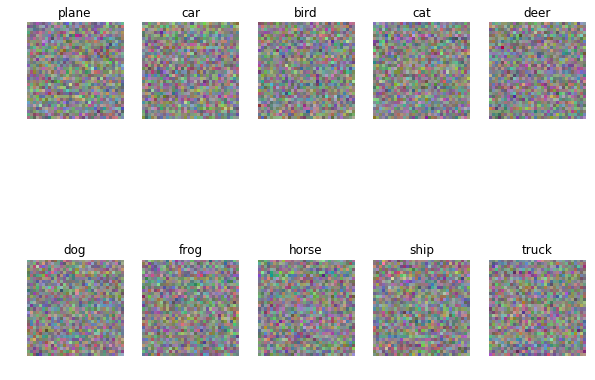

In [107]:
# Visualize the learned weights for each class
w = clf_best.W[:,:-1] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])